## AIF360 package

https://github.com/Trusted-AI/AIF360

https://aif360.readthedocs.io/en/stable/


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import CompasDataset
import pandas as pd
import numpy as np

# Load the COMPAS dataset
dataset = CompasDataset()

# Split features and labels
X = dataset.features
y = dataset.labels.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a function for model evaluation
def evaluate_model(hyperparameters):
    
    model = LogisticRegression(**hyperparameters)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df = pd.DataFrame(X_test, columns=dataset.feature_names)
    df['two_year_recid'] = y_test 

    # Create the BinaryLabelDataset
    test_dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=df,
        label_names=['two_year_recid'],
        protected_attribute_names=['race']
    )

    # Evaluate fairness metric
    metric = BinaryLabelDatasetMetric(
        test_dataset,
        privileged_groups=[{'race': 1}],  # Privileged group: White
        unprivileged_groups=[{'race': 0}]  # Unprivileged group: Non-white
    )

    # Compute error rate
    error_rate = np.mean(y_pred != y_test)

    # Return results
    return {
        'error_rate': error_rate,
        'statistical_parity_difference': metric.statistical_parity_difference()
    }


# Example usage
hyperparameters = {'C': 1.0, 'solver': 'lbfgs', 'max_iter': 100}
results = evaluate_model(hyperparameters)
print(f"Error Rate: {results['error_rate']}")
print(f"Statistical Parity Difference: {results['statistical_parity_difference']}")


## Multi-Objective Model with COMPAS dataset + Dyrcors and Pareto Sampling

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from aif360.datasets import BinaryLabelDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from scipy.stats import truncnorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

#mapping functions:
def map_solver_to_index(value):
    solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
    num_solvers = len(solvers)
    epsilon = 1e-8  #small value to prevent reaching 1.0

    #clip the value to [0, 1 - epsilon) to avoid index out of range
    value_clipped = np.clip(value, 0, 1 - epsilon)

    #getting the index
    index = int(value_clipped * num_solvers)

    return index

def map_index_to_solver(index):
    solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
    if 0 <= index < len(solvers):
        return solvers[index]
    else:
        raise ValueError(f"Invalid solver index: {index}")

#hyperparameter validation
def validate_hyperparameters(hp_dict):
    #checking if 'max_iter' is positive
    if hp_dict['max_iter'] <= 0:
        return False
    return True

#sample generating function
from skopt.space import Space, Real, Integer
from skopt.sampler import Lhs

def generate_lhs_samples(
    dim, 
    lb, 
    ub, 
    NN=None, 
    n_seeds=3, 
    output_dir='./fairpilot-hyperparams', 
    use_integer=False, 
    criterion="maximin", 
    iterations=10000,
    step_sizes=None 
):
    os.makedirs(output_dir, exist_ok=True)
    
    #determining the type of space Real\Integer for each hyperparameter
    if use_integer:
        space = Space([Integer(lb[i], ub[i]) for i in range(dim)])
    else:
        space = Space([Real(lb[i], ub[i]) for i in range(dim)])
    
    #default value for NN if not provided
    if NN is None:
        NN = 2 * (dim + 1)
    
    #initializing LHS sampler
    lhs = Lhs(criterion=criterion, iterations=iterations)
    
    #generate LHS samples for each seed
    Xlabeled = []
    for seed in range(n_seeds):
        samples = lhs.generate(space.dimensions, NN, random_state=seed)
        Xlabeled.extend(samples)
    
    Xlabeled = np.array(Xlabeled)
    
    #apply step sizes to dimensions if provided
    if step_sizes is not None:
        for i, step_size in enumerate(step_sizes):
            if step_size is not None:  #apply only if a step size is defined
                Xlabeled[:, i] = np.round(Xlabeled[:, i] / step_size) * step_size
    

    #save initial hyperparmeter samples
    df = pd.DataFrame(Xlabeled, columns=[f'Param_{i+1}' for i in range(dim)])
    pool_filename = f'pool_initial.csv'
    pool_path = os.path.join(output_dir, pool_filename)
    df.to_csv(pool_path, index=False)
    print(f"Generated initial samples and saved to {pool_path}")
    
    return Xlabeled

#sample loading\processing
def process_initial_samples(X_continuous):
    X_processed = X_continuous.copy()
    #assuming 'solver' is the 2nd hyperparameter (index 1)
    X_processed[:, 1] = [map_solver_to_index(val) for val in X_continuous[:, 1]]
    #round 'max_iter' to the nearest integer
    X_processed[:, 2] = np.round(X_continuous[:, 2]).astype(int)
    return X_processed

def load_initial_samples(output_dir, pool_filename='pool_initial.csv'):
    pool_path = os.path.join(output_dir, pool_filename)
    if not os.path.exists(pool_path):
        raise FileNotFoundError(f"Pool file '{pool_path}' does not exist.")
    df = pd.read_csv(pool_path)
    X_init_continuous = df.values  #shape:(n_samples, d)
    X_init = process_initial_samples(X_init_continuous)
    return X_init

#evaluation function
def evaluate_model(hyperparameters):
    try:
        #decode the solver index back to its string representation
        solver_index = hyperparameters[1]
        solver_str = map_index_to_solver(int(solver_index))
        
        #a dictionary with the decoded solver
        hp_dict = {
            'C': hyperparameters[0],
            'solver': solver_str,
            'max_iter': int(hyperparameters[2])
        }
        
        #validating hyperparameters
        if not validate_hyperparameters(hp_dict):
            raise ValueError("invalid hyperparameters.")
        
        #initialize and train the model
        model = LogisticRegression(**hp_dict)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        #prepare the dataset for fairness evaluation
        df = pd.DataFrame(X_test, columns=dataset.feature_names)
        df['two_year_recid'] = y_pred

        #create the BinaryLabelDataset
        test_dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df,
            label_names=['two_year_recid'],
            protected_attribute_names=['race']
        )

        #evaluate fairness metric
        metric = BinaryLabelDatasetMetric(
            test_dataset,
            privileged_groups=[{'race': 1}],  #privileged group: White
            unprivileged_groups=[{'race': 0}]  #unprivileged group: Non-white
        )

        #compute error rate (1 - F1 Score)
        from sklearn.metrics import f1_score
        f1 = f1_score(y_test, y_pred)
        error_rate = 1 - f1

        #compute statistical parity difference
        statistical_parity_difference = metric.statistical_parity_difference()

        #I will return the results as a 1D array
        return np.array([error_rate, statistical_parity_difference])
    except Exception as e:
        print(f"Error evaluating model with hyperparameters {hyperparameters}: {e}")
        #log the problematic hyperparameters for further analysis
        with open("evaluation_errors.log", "a") as log_file:
            log_file.write(f"Error with hyperparameters {hyperparameters}: {e}\n")
        #return large finite values instead of infinity
        return np.array([1e6, 1e6])  #assign large finite values

#pareto front identification
def identify_pareto_front(Y):
    
    #identify the pareto front from a set of objective values.
    #input:Y (ndarray): Objective values, shape (n_samples, m).    
    #output:pareto_indices (list): Indices of Pareto optimal points.

    pareto_indices = []
    num_points = Y.shape[0]
    for i in range(num_points):
        dominated = False
        for j in range(num_points):
            if all(Y[j] <= Y[i]) and any(Y[j] < Y[i]):
                dominated = True
                break
        if not dominated:
            pareto_indices.append(i)
    return pareto_indices

#DyCORS candidate generation
def dycors(xbest, num_cand, lb, up, scalefactor, d):

    #generate candidate samples around the best point using DyCORS.
    
    #input:xbest (ndarray): best hyperparameter point, shape (d,).
        #num_cand (int): number of candidate samples to generate.
        #lb (ndarray): lower bounds, shape (d,).
        #up (ndarray): upper bounds, shape (d,).
        #scalefactor (float): scaling factor for perturbation.
        #d (int): number of dimensions.
    
    #output:sp (ndarray): generated candidate samples, shape (num_cand, d).

    subset = np.arange(0, d) 
    prob_perturb = 1 #KEEP THIS EQUAL TO 1
    
    #generate candidate points
    ar = np.random.rand(num_cand, len(subset)) < prob_perturb
    ind = np.where(np.sum(ar, axis=1) == 0)[0]
    if len(ind) > 0:
        ar[ind, np.random.randint(0, len(subset), size=len(ind))] = 1
    cand = np.tile(xbest, (num_cand, 1))
    for i in subset:
        lower, upper, sigma = lb[i], up[i], scalefactor
        indices = np.where(ar[:, i] == 1)[0]
        if len(indices) > 0:
            p = truncnorm.rvs(
                a=(lower - xbest[i]) / sigma, b=(upper - xbest[i]) / sigma, 
                loc=xbest[i], scale=sigma, 
                size=len(indices)
            )
            cand[indices, i] = p  
    sp = np.array(cand)       
    return sp 

#GPs
def gp_fit(X, Y):

    #we fit GPs for each objective.
    #input:
    # X (ndarray): hyperparameter points, shape (n_samples, d).
    # Y (ndarray): objective values, shape (n_samples, m).
    
    #output:GPs, list of fitted GP models for each objective.

    models = []
    for i in range(Y.shape[1]):
        kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1))
        gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
        gp_model.fit(X, Y[:, i])
        models.append(gp_model)
    return models

def gp_predict(models, X_pred):
   
    #predict objective values using fitted GP models.
    #input:
        #models: list of fitted GPs.
        #X_pred: candidate hyperparameter points, shape (n_cand, d).
    
    #output: Y_pred (ndarray): predicted objective means, shape (n_cand, m).

    means = []
    for model in models:
        mean, _ = model.predict(X_pred, return_std=True)
        means.append(mean)
    Y_pred = np.vstack(means).T
    return Y_pred

#BO Class
class My_BO:
    def __init__(self, B, d, func, Strategy, Init_X, Init_Y, Cand_size, batch_size, lb, up):
      
        self.Budget = B  # total evaluation budget 
        self.dimension = d  # number of hyperparameters 
        self.Strategy = Strategy  # sampling strategy 
        self.func = func  #black-box function 
        self.X = Init_X.copy()  # evaluated hyperparameter points 
        self.F1 = Init_Y[:, 0].copy()  # objective 1: Accuracy
        self.F2 = Init_Y[:, 1].copy()  #objective 2: Fairness
        self.Cand_size = Cand_size  # number of candidates to generate
        self.batch_size = batch_size  #number of points to query per iteration
        self.lb = lb  # lower bounds
        self.up = up  #upper bounds
        self.iteration = 0  #iteration counter
    
    def fit_surrogates(self):
        
        #fit Gaussian Process surrogate models for both objectives.
        Y = np.vstack([self.F1, self.F2]).T  #shape: (n_samples, 2)
        self.models = gp_fit(self.X, Y)
    
    def generate_candidates(self):
        
        #generate candidate hyperparameter points based on best F1 and F2.
        #output:candidates (ndarray):candidate hyperparameter points, shape (2*Cand_size, d).
    
        #identify best points based on F1 and F2
        best_f1_idx = np.argmin(self.F1)
        best_f2_idx = np.argmin(self.F2)
        best_f1 = self.X[best_f1_idx]
        best_f2 = self.X[best_f2_idx]
        
        #generate candidates around best_f1 and best_f2
        cand1 = dycors(best_f1, self.Cand_size, self.lb, self.up, scalefactor=0.3, d=self.dimension)
        cand2 = dycors(best_f2, self.Cand_size, self.lb, self.up, scalefactor=0.3, d=self.dimension)
        
        #combine candidates
        candidates = np.vstack([cand1, cand2])
        
        # double checking that my candidates are within bounds
        candidates = np.clip(candidates, self.lb, self.up)
        
        return candidates
    
    def select_pareto_candidates(self, Y_pred, candidates):
      
        #select Pareto optimal candidates.
        
        #inoput:Y_pred (ndarray): Predicted objectives, shape (n_cand, 2).
            #candidates (ndarray): Candidate hyperparameter points, shape (n_cand, d).
        
        #output:S (ndarray): Selected Pareto optimal points, shape (k, d) or less.
   
        pareto_indices = identify_pareto_front(Y_pred)
        S_candidates = candidates[pareto_indices]
        
        return S_candidates
    
    def round_categorical(self, S):
        #round categorical hyperparameters to valid integer indices.
        #inout:S (ndarray): Selected hyperparameter points, shape (n_selected, d).
        #output:S_rounded (ndarray): Rounded hyperparameter points, shape (n_selected, d).
    
        S_rounded = S.copy()
        #assuming 'solver' is the second hyperparameter (index 1)
        S_rounded[:, 1] = np.round(S[:, 1]).astype(int)
        #checking 'solver' index is within valid range
        num_solvers = 4
        S_rounded[:, 1] = np.clip(S_rounded[:, 1], 0, num_solvers - 1)
        #round 'max_iter' to integer
        S_rounded[:, 2] = np.round(S[:, 2]).astype(int)
        return S_rounded
    
    def evaluate_candidates(self, S):

        #evaluate selected candidate hyperparameter points.
        #inpout:
            #S (ndarray): selected hyperparameter points, shape (n_selected, d).
        #output:
            #F1_new (ndarray): evaluated F1 for new points, shape (n_selected,).
            #F2_new (ndarray): evaluated F2 for new points, shape (n_selected,).
      
        F1_new = []
        F2_new = []
        for hp in S:
            objectives = self.func(hp)
            F1_new.append(objectives[0])
            F2_new.append(objectives[1])
        return np.array(F1_new), np.array(F2_new)
    
    def run(self):
  
        #run the BO loop.
        
        #output:
            #X_final (ndarray): Final hyperparameter points, shape (n_final, d).
            #F1_final (ndarray): Final F1 objectives, shape (n_final,).
            #F2_final (ndarray): Final F2 objectives, shape (n_final,).
            #duration (float): Total time taken, in seconds.
        import time
        start_time = time.time()
        
        while self.Budget > 0:
            self.iteration += 1
            print(f"=== Iteration {self.iteration} ===")
            print(f"Remaining Budget: {self.Budget}")
            print(f"Evaluated Set Size: {self.X.shape}")
            
            # Fit surrogate models
            self.fit_surrogates()
            
            # Generate candidates
            candidates = self.generate_candidates()
            print(f"Generated {candidates.shape[0]} candidates.")
            
            # Predict objectives for candidates
            Y_pred = gp_predict(self.models, candidates)
            
            # Select Pareto optimal candidates
            S_candidates = self.select_pareto_candidates(Y_pred, candidates)
            print(f"Pareto optimal candidates found: {S_candidates.shape[0]}")
            
            if S_candidates.shape[0] >= self.batch_size:
                # Select k candidates at random from S_candidates
                selected_indices = np.random.choice(S_candidates.shape[0], self.batch_size, replace=False)
                S_selected = S_candidates[selected_indices]
            else:
                # Select all Pareto candidates
                S_selected = S_candidates
            
            # Round categorical hyperparameters
            S_selected = self.round_categorical(S_selected)
            
            # Evaluate selected candidates
            F1_new, F2_new = self.evaluate_candidates(S_selected)
            print(f"Evaluated {len(F1_new)} new candidates.")
            
            # Append new evaluations to the labeled set
            self.X = np.vstack([self.X, S_selected])
            self.F1 = np.append(self.F1, F1_new)
            self.F2 = np.append(self.F2, F2_new)
            
            # Update budget
            self.Budget -= len(S_selected)
            
            print(f"Budget left: {self.Budget}")
            print("============================\n")
        
        end_time = time.time()
        duration = end_time - start_time
        print(f"=== Optimization Completed in {duration:.2f} seconds ===")
        
        return self.X, self.F1, self.F2, duration

# --- Load Dataset ---
# Load the COMPAS dataset
dataset = CompasDataset()

# Split features and labels
X = dataset.features
y = dataset.labels.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Generate Initial LHS Samples ---
output_dir = './fairpilot-hyperparams'
initial_pool_filename = 'pool_initial.csv'

# Check if initial samples already exist
if not os.path.exists(os.path.join(output_dir, initial_pool_filename)):
    print("Generating initial LHS samples...")
    Xlabeled_continuous = generate_lhs_samples(
        dim=3,                 #number of hyperparameters: 'C', 'solver', 'max_iter'
        lb=[0.001, 0, 100],    #lower bounds for 'C', 'solver', 'max_iter'
        ub=[1000, 1, 500],     #upper bounds for 'C', 'solver', 'max_iter'
        NN=None,               
        n_seeds=3,            
        output_dir=output_dir,
        use_integer=False,     
        criterion="maximin",   
        iterations=10000,
        step_sizes=[None, None, 50] #step size only for the max iteration       
    )
else:
    print("Initial LHS samples already exist.")

# --- Load Initial Samples ---
X_init = load_initial_samples(output_dir, pool_filename=initial_pool_filename)
print(f"Loaded initial samples:\n{X_init}")

#process initial samples (encode categorical variables)
# already handled in load_initial_samples

#evaluate initial samples 
def evaluate_initial_samples(X_init, evaluate_func):
    
    #evaluate each initial hyperparameter set.
    
    #input:
        #X_init (ndarray): initial hyperparameter points, shape (n_samples, d).
        #evaluate_func (callable): function to evaluate a hyperparameter set.
    #output:Y_init (ndarray): evaluated objectives, shape (n_samples, m).

    Y_init = np.array([evaluate_func(hp) for hp in X_init])
    return Y_init

Y_init = evaluate_initial_samples(X_init, evaluate_model)
print(f"Evaluated objectives for initial samples:\n{Y_init}")

#initialize and run bayesian optimization
#define hyperparameter bounds
lb = np.array([0.001, 0, 100])  #lower bounds for 'C', 'solver', 'max_iter'
up = np.array([1000, 1, 500])   #upper bounds for 'C', 'solver', 'max_iter'

#defining batch size and maximum budget
d = 3  #number of hyperparameters
batch_size = 2  #adjust as needed
max_budget = 100 * d  #total budget

#initiate the BO class
bo = My_BO(
    B=max_budget - X_init.shape[0],  #remaining budget after initial samples
    d=d, 
    func=evaluate_model,
    Strategy='Pareto',  #currently only 'Pareto' is implemented
    Init_X=X_init,
    Init_Y=Y_init,
    Cand_size=1500,  #number of candidates to generate using DyCORS
    batch_size=batch_size,    #number of points to query in each iteration
    lb=lb,
    up=up
)

#running the optimization
final_X, final_F1, final_F2, duration = bo.run()

#save results to CSV
results_df = pd.DataFrame(final_X, columns=['C', 'solver', 'max_iter'])
results_df['error_rate'] = final_F1
results_df['statistical_parity_difference'] = final_F2
results_df['duration_seconds'] = duration
results_df.to_csv('BO_Pareto_results.csv', index=False)
print("Results saved to 'BO_Pareto_results.csv'.")

#identify pareto front
pareto_indices = identify_pareto_front(np.vstack([final_F1, final_F2]).T)
pareto_Y = np.vstack([final_F1, final_F2]).T[pareto_indices]

print(f"Pareto Front Indices: {pareto_indices}")
print(f"Pareto Front Objectives:\n{pareto_Y}")

#plot pareto front
plt.figure(figsize=(10, 7))
plt.scatter(final_F1, final_F2, label='All Points', alpha=0.6)
plt.scatter(pareto_Y[:, 0], pareto_Y[:, 1], color='red', label='Pareto Front', alpha=0.8)
plt.xlabel('Error Rate (1 - F1 Score)')
plt.ylabel('Statistical Parity Difference')
plt.title('Pareto Front in Hyperparameter Optimization')
plt.legend()
plt.grid(True)
plt.savefig('Pareto_Front.png')
plt.show()


## Debugging cells:

In [10]:
#evaluation function
def evaluate_model(hyperparameters):
    try:
        #decode the solver index back to its string representation
        solver_index = hyperparameters[1]
        solver_str = map_index_to_solver(int(solver_index))
        
        #a dictionary with the decoded solver
        hp_dict = {
            'C': hyperparameters[0],
            'solver': solver_str,
            'max_iter': int(hyperparameters[2])
        }
        
        #validating hyperparameters
        if not validate_hyperparameters(hp_dict):
            raise ValueError("invalid hyperparameters.")
        
        #initialize and train the model
        model = LogisticRegression(**hp_dict)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        #prepare the dataset for fairness evaluation
        df = pd.DataFrame(X_test, columns=dataset.feature_names)
        df['two_year_recid'] = y_test 

        #create the BinaryLabelDataset
        test_dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df,
            label_names=['two_year_recid'],
            protected_attribute_names=['race']
        )

        #evaluate fairness metric
        metric = BinaryLabelDatasetMetric(
            test_dataset,
            privileged_groups=[{'race': 1}],  #privileged group: White
            unprivileged_groups=[{'race': 0}]  #unprivileged group: Non-white
        )

        #compute error rate (1 - F1 Score)
        from sklearn.metrics import f1_score
        f1 = f1_score(y_test, y_pred)
        error_rate = 1 - f1

        #compute statistical parity difference
        statistical_parity_difference = metric.statistical_parity_difference()

        #I will return the results as a 1D array
        return np.array([error_rate, statistical_parity_difference])
    except Exception as e:
        print(f"Error evaluating model with hyperparameters {hyperparameters}: {e}")
        #log the problematic hyperparameters for further analysis
        with open("evaluation_errors.log", "a") as log_file:
            log_file.write(f"Error with hyperparameters {hyperparameters}: {e}\n")
        #return large finite values instead of infinity
        return np.array([1e6, 1e6])  #assign large finite values


In [78]:
# from sklearn.ensemble import RandomForestClassifier
model = LogisticRegression(**hp_dict)
# model = RandomForestClassifier(**hp_dict)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
        
        #prepare the dataset for fairness evaluation
df = pd.DataFrame(X_test, columns=dataset.feature_names)
df['two_year_recid'] = y_pred 

        #create the BinaryLabelDataset
test_dataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df,
    label_names=['two_year_recid'],
    protected_attribute_names=['race']
)

        #evaluate fairness metric
metric = BinaryLabelDatasetMetric(
    test_dataset,
    privileged_groups=[{'race': 1}],  #privileged group: White
    unprivileged_groups=[{'race': 0}]  #unprivileged group: Non-white
)


# ## metrics
#     met_arr=[]
#     y_val_pred = fitted.predict(test.features)
#     dataset_pred = test.copy()
#     #print(‘Testing Accuracy’,fitted.score(test.features,test.labels.ravel()))
#     #dataset_pred.labels = y_val_pred
    
#     dataset_pred.labels = y_val_pred
#     #print(dataset_pred)
#     metric = ClassificationMetric(test, dataset_pred,
#             unprivileged_groups=unprivileged_groups,
#             privileged_groups=privileged_groups)


#compute error rate (1 - F1 Score)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
error_rate = 1 - f1

#compute statistical parity difference
statistical_parity_difference = metric.statistical_parity_difference()
# statistical_parity_difference = metric.disparate_impact()





## EHVI Model

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Initial LHS samples already exist. Loading them...
Loaded initial samples:
[[483.79146012   0.         496.        ]
 [309.72688264   2.         151.        ]
 [592.42737257   3.         321.        ]
 [984.84153259   1.         394.        ]
 [866.16302192   3.         113.        ]
 [ 31.04570186   2.         414.        ]
 [129.50519949   0.         226.        ]
 [651.51875119   1.         253.        ]
 [593.57440032   0.         301.        ]
 [277.19111407   2.         247.        ]
 [793.30823403   2.         356.        ]
 [ 27.6494042    1.         169.        ]
 [441.69887705   3.         445.        ]
 [892.39960645   1.         146.        ]
 [133.51122704   0.         496.        ]
 [746.48074084   3.         277.        ]
 [121.31362258   3.         302.        ]
 [334.1261492    2.         107.        ]
 [586.48075502   0.         197.        ]
 [701.39706827   3.         398.        ]
 [148.04270918   1.         290.        ]
 [967.30110825   2.         234.        ]
 

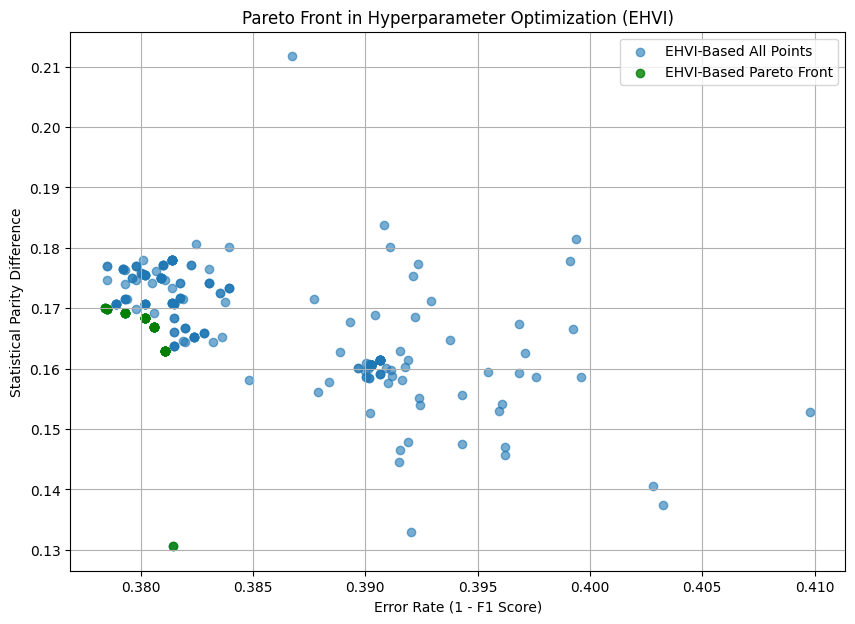

In [1]:
# --- Imports ---
import os
import numpy as np
import pandas as pd
import random
import warnings
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from aif360.datasets import BinaryLabelDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Botorch and GPyTorch Imports for EHVI
import torch
from botorch.models import SingleTaskGP
from botorch.models import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.multi_objective import qExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions import NondominatedPartitioning
from botorch.sampling import SobolQMCNormalSampler, SobolEngine
from botorch.optim import optimize_acqf_discrete
from botorch.models import ModelListGP
import gpytorch

# --- Suppress Specific Warnings ---
warnings.filterwarnings('ignore')

# --- Set Random Seeds for Reproducibility ---
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# --- Mapping Functions ---
def map_solver_to_index(value):
    solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
    num_solvers = len(solvers)
    epsilon = 1e-8
    value_clipped = np.clip(value, 0, 1 - epsilon)
    index = int(value_clipped * num_solvers)
    return index

def map_index_to_solver(index):
    solvers = ['lbfgs', 'liblinear', 'sag', 'saga']
    if 0 <= index < len(solvers):
        return solvers[index]
    else:
        raise ValueError(f"Invalid solver index: {index}")

# --- Hyperparameter Validation ---
def validate_hyperparameters(hp_dict):
    if hp_dict['max_iter'] <= 0:
        return False
    return True

# --- Sample Loading and Processing ---
def process_initial_samples(X_continuous):
    X_processed = X_continuous.copy()
    X_processed[:, 1] = [map_solver_to_index(val) for val in X_continuous[:, 1]]
    X_processed[:, 2] = np.round(X_continuous[:, 2]).astype(int)
    return X_processed

def load_initial_samples(output_dir, pool_filename='pool_initial.csv'):
    pool_path = os.path.join(output_dir, pool_filename)
    if not os.path.exists(pool_path):
        raise FileNotFoundError(f"Pool file '{pool_path}' does not exist.")
    df = pd.read_csv(pool_path)
    X_init_continuous = df.values
    X_init = process_initial_samples(X_init_continuous)
    return X_init

# --- Evaluation Function ---
def evaluate_model(x):
    try:
        solver_index = x[1]
        solver_str = map_index_to_solver(int(solver_index))
    except ValueError as ve:
        print(f"Invalid solver index {solver_index}: {ve}")
        return (1e6, 1e6)
    
    hyperparams = {
        'C': x[0],
        'solver': solver_str,
        'max_iter': int(x[2])
    }
    
    try:
        if not validate_hyperparameters(hyperparams):
            raise ValueError("Invalid hyperparameters.")
        
        model = LogisticRegression(**hyperparams)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1 = f1_score(y_test, y_pred)
        error_rate = 1 - f1
        
        df = pd.DataFrame(X_test, columns=dataset.feature_names)
        df['two_year_recid'] = y_pred 
        test_dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df,
            label_names=['two_year_recid'],
            protected_attribute_names=['race']
        )
        metric = BinaryLabelDatasetMetric(
            test_dataset,
            privileged_groups=[{'race': 1}],
            unprivileged_groups=[{'race': 0}]
        )
        statistical_parity_difference = metric.statistical_parity_difference()
        
        return (error_rate, statistical_parity_difference)
    except Exception as e:
        print(f"Error evaluating model with hyperparameters {hyperparams}: {e}")
        with open("evaluation_errors.log", "a") as log_file:
            log_file.write(f"Error with hyperparameters {hyperparams}: {e}\n")
        return (1e6, 1e6)

# --- Pareto Front Identification ---
def identify_pareto_front(Y):
    pareto_indices = []
    num_points = Y.shape[0]
    for i in range(num_points):
        dominated = False
        for j in range(num_points):
            if all(Y[j] <= Y[i]) and any(Y[j] < Y[i]):
                dominated = True
                break
        if not dominated:
            pareto_indices.append(i)
    return pareto_indices

# --- Botorch GP Fit Function ---
def gp_fit_botorch(X, Y):
    models = []
    for i in range(Y.shape[1]):
        train_X = torch.tensor(X, dtype=torch.float32)
        train_Y = torch.tensor(Y[:, i], dtype=torch.float32).unsqueeze(-1)
        gp = SingleTaskGP(train_X, train_Y)
        gp.mean_module = gpytorch.means.ConstantMean()
        gp.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=X.shape[1])
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_model(mll)
        models.append(gp)
    return ModelListGP(*models)




# --- EHVI-Based Bayesian Optimization Class ---
class My_EHVI_BO:
    def __init__(self, B, d, func, Init_X, Init_Y, pool_size, batch_size, lb, up):
        self.Budget = B
        self.dimension = d
        self.func = func
        self.X = Init_X.copy()
        self.F1 = Init_Y[:, 0].copy()
        self.F2 = Init_Y[:, 1].copy()
        self.pool_size = pool_size
        self.batch_size = batch_size
        self.lb = lb
        self.up = up
        self.iteration = 0
        self.model = None
    
    def fit_surrogates(self):
        Y = np.vstack([self.F1, self.F2]).T
        self.model = gp_fit_botorch(self.X, Y)
    
    def generate_candidates(self):
        sobol_engine = SobolEngine(dimension=self.dimension, scramble=True)
        candidate_set = sobol_engine.draw(self.pool_size).numpy()
        candidate_set = self.lb + (self.up - self.lb) * candidate_set
        return candidate_set
    
    def select_ehvi_candidates(self, model, candidates, ref_point):
        candidates_torch = torch.from_numpy(candidates).float()
        Y_observed = torch.from_numpy(np.vstack([self.F1, self.F2]).T).float()
        partitioning = NondominatedPartitioning(ref_point=torch.from_numpy(ref_point).float(), Y=Y_observed)
        sampler = SobolQMCNormalSampler(sample_shape=torch.Size([1000]))
        aq = qExpectedHypervolumeImprovement(
            model=model, 
            ref_point=ref_point.tolist(),
            partitioning=partitioning,
            sampler=sampler,
        )

        selected_candidates, acq_value = optimize_acqf_discrete(
            acq_function=aq,
            q=self.batch_size,
            choices=candidates_torch,
            unique=True,
        )
        selected_candidates = selected_candidates.detach().cpu().numpy()
        return selected_candidates
    
    def round_categorical(self, S):
        S_rounded = S.copy()
        S_rounded[:, 1] = np.round(S[:, 1]).astype(int)
        num_solvers = 4
        S_rounded[:, 1] = np.clip(S_rounded[:, 1], 0, num_solvers - 1)
        S_rounded[:, 2] = np.round(S[:, 2]).astype(int)
        return S_rounded
    
    def evaluate_candidates(self, S):
        F1_new = []
        F2_new = []
        for hp in S:
            objectives = self.func(hp)
            F1_new.append(objectives[0])
            F2_new.append(objectives[1])
        return np.array(F1_new), np.array(F2_new)
    
    def run(self):
        start_time = time.time()
        
        while self.Budget > 0:
            self.iteration += 1
            print(f"=== Iteration {self.iteration} ===")
            print(f"Remaining Budget: {self.Budget}")
            print(f"Evaluated Set Size: {self.X.shape}")
            
            self.fit_surrogates()
            candidates = self.generate_candidates()
            print(f"Generated {candidates.shape[0]} candidates.")
            
            ref_point = np.min(np.vstack([self.F1, self.F2]).T, axis=0) - 1e-4
            
            selected_candidates = self.select_ehvi_candidates(model=self.model, candidates=candidates, ref_point=ref_point)
            print(f"Selected {selected_candidates.shape[0]} candidates based on EHVI.")
            
            selected_candidates = self.round_categorical(selected_candidates)
            
            F1_new, F2_new = self.evaluate_candidates(selected_candidates)
            print(f"Evaluated {len(F1_new)} new candidates.")
            
            self.X = np.vstack([self.X, selected_candidates])
            self.F1 = np.append(self.F1, F1_new)
            self.F2 = np.append(self.F2, F2_new)
            
            self.Budget -= len(selected_candidates)
            
            print(f"Budget left: {self.Budget}")
            print("============================\n")
        
        end_time = time.time()
        duration = end_time - start_time
        print(f"=== Optimization Completed in {duration:.2f} seconds ===")
        
        return self.X, self.F1, self.F2, duration

# --- Load Dataset ---
dataset = CompasDataset()
X = dataset.features
y = dataset.labels.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Generate and Load Initial LHS Samples ---
output_dir = './fairpilot-hyperparams'
initial_pool_filename = 'pool_initial.csv'

if not os.path.exists(os.path.join(output_dir, initial_pool_filename)):
    raise FileNotFoundError(f"Initial pool file '{initial_pool_filename}' does not exist in '{output_dir}'. Please ensure it is generated by the DyCORS-based BO model.")
else:
    print("Initial LHS samples already exist. Loading them...")

# --- Load Initial Samples ---
X_init = load_initial_samples(output_dir, pool_filename=initial_pool_filename)
print(f"Loaded initial samples:\n{X_init}")

# --- Evaluate Initial Samples ---
def evaluate_initial_samples(X_init, evaluate_func):
    Y_init = np.array([evaluate_func(hp) for hp in X_init])
    return Y_init

Y_init = evaluate_initial_samples(X_init, evaluate_model)
print(f"Evaluated objectives for initial samples:\n{Y_init}")

# --- Define Hyperparameter Bounds ---
lb = np.array([0.001, 0, 100])  # lower bounds for 'C', 'solver', 'max_iter'
up = np.array([1000, 3, 500])   # upper bounds for 'C', 'solver', 'max_iter'

# --- Define Batch Size and Maximum Budget ---
d = 3  # number of hyperparameters
batch_size = 2  # adjust as needed
max_budget = 100 * d  # total budget

# --- Initialize and Run EHVI-Based Bayesian Optimization ---
bo_ehvi = My_EHVI_BO(
    B=max_budget - X_init.shape[0],
    d=d, 
    func=evaluate_model,
    Init_X=X_init,
    Init_Y=Y_init,
    pool_size=50,  # Reduced for testing
    batch_size=batch_size,
    lb=lb,
    up=up
)

# Run the EHVI-Based Bayesian Optimization
final_X_ehvi, final_F1_ehvi, final_F2_ehvi, duration_ehvi = bo_ehvi.run()

# --- Save EHVI-Based Results ---
results_df_ehvi = pd.DataFrame(final_X_ehvi, columns=['C', 'solver', 'max_iter'])
results_df_ehvi['error_rate'] = final_F1_ehvi
results_df_ehvi['statistical_parity_difference'] = final_F2_ehvi
results_df_ehvi['duration_seconds'] = duration_ehvi
results_df_ehvi.to_csv('BO_EHVI_results.csv', index=False)
print("EHVI-Based BO Results saved to 'BO_EHVI_results.csv'.")

# --- Identify Pareto Front ---
pareto_indices_ehvi = identify_pareto_front(np.vstack([final_F1_ehvi, final_F2_ehvi]).T)
pareto_Y_ehvi = np.vstack([final_F1_ehvi, final_F2_ehvi]).T[pareto_indices_ehvi]

print(f"Pareto Front Indices (EHVI): {pareto_indices_ehvi}")
print(f"Pareto Front Objectives (EHVI):\n{pareto_Y_ehvi}")

# --- Plot Pareto Front ---
plt.figure(figsize=(10, 7))
plt.scatter(final_F1_ehvi, final_F2_ehvi, label='EHVI-Based All Points', alpha=0.6)
plt.scatter(pareto_Y_ehvi[:, 0], pareto_Y_ehvi[:, 1], color='orange', label='EHVI-Based Pareto Front', alpha=0.8)
plt.xlabel('Error Rate (1 - F1 Score)')
plt.ylabel('Statistical Parity Difference')
plt.title('Pareto Front in Hyperparameter Optimization (EHVI)')
plt.legend()
plt.grid(True)
plt.savefig('EHVI_Pareto_Front.png')
plt.show()
